In [4]:
# 1. Import thư viện cần thiết
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

Mounted at /content/drive


In [5]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/Data Analysis/DIG_Stock.csv')
df1=df.reset_index()['Price']

In [6]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [7]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [8]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [9]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [10]:
# 7. Reshape input to be [samples, time steps, features] which is required for RNN
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [11]:
# 8. Define RNN Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
14/14 [==============================] - 3s 80ms/step - loss: 0.0058 - val_loss: 0.0554
Epoch 2/100
14/14 [==============================] - 1s 47ms/step - loss: 4.5060e-04 - val_loss: 0.0117
Epoch 3/100
14/14 [==============================] - 1s 47ms/step - loss: 1.6571e-04 - val_loss: 0.0077
Epoch 4/100
14/14 [==============================] - 1s 45ms/step - loss: 1.0774e-04 - val_loss: 0.0071
Epoch 5/100
14/14 [==============================] - 1s 48ms/step - loss: 9.4532e-05 - val_loss: 0.0058
Epoch 6/100
14/14 [==============================] - 1s 51ms/step - loss: 9.1903e-05 - val_loss: 0.0057
Epoch 7/100
14/14 [==============================] - 0s 24ms/step - loss: 8.8251e-05 - val_loss: 0.0053
Epoch 8/100
14/14 [==============================] - 0s 28ms/step - loss: 8.7179e-05 - val_loss: 0.0053
Epoch 9/100
14/14 [==============================] - 0s 27ms/step - loss: 8.4740e-05 - val_loss: 0.0048
Epoch 10/100
14/14 [==============================] - 0s 26ms/step -

In [14]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 11ms/step


In [15]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [16]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [17]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 850.6367970365109
Testing RMSE: 2439.622310827948


In [18]:
valid_mape = np.mean(abs((yval - y_pred_val) / yval)) * 100
test_mape = np.mean(abs((ytest - y_pred) / ytest)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 3.438433600396542
Testing MAPE: 4.82702694475271


In [19]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=79
i=0
while(i<30):

    if(len(temp_input)>79):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.14325438]
80
1 day input [0.08414615 0.08360033 0.07868793 0.07213806 0.075413   0.06558819
 0.06558819 0.05630921 0.06504237 0.0584925  0.06122162 0.06012997
 0.05685504 0.05467175 0.04812188 0.05630921 0.05903833 0.06395073
 0.05576339 0.05958415 0.06176744 0.06449655 0.06722566 0.07268388
 0.06886313 0.07159224 0.06886313 0.075413   0.0852378  0.09069602
 0.09724589 0.10161247 0.11362056 0.11798714 0.11907878 0.11580385
 0.11798714 0.1048874  0.10597905 0.11798714 0.11362056 0.11525803
 0.1147122  0.11252891 0.1048874  0.11252891 0.11907878 0.13217852
 0.13436181 0.13599928 0.13381599 0.12999523 0.13709092 0.1512823
 0.15346559 0.14855319 0.15728635 0.15510306 0.13927421 0.15182812
 0.15182812 0.15291977 0.15564888 0.15237395 0.15510306 0.1561947
 0.15674052 0.1611071  0.16984026 0.1660195  0.15946964 0.1611071
 0.16820279 0.15510306 0.1561947  0.14909901 0.15674052 0.15182812
 0.14325438]
1 day output [[0.14188403]]
2 day input [0.08360033 0.07868793 0.07213806 0.075413   0.0655

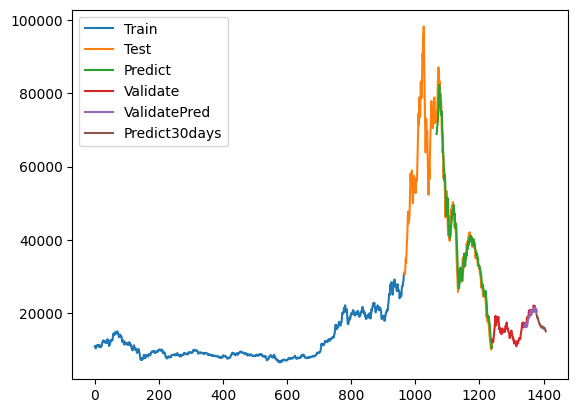

In [20]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()